<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Brain_Tumor_Detection_YOLOv8_CV_SAM_axial_t1wce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Brain tumor object detection datasets](https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets)

## Refference

- [Brain Tumor Detection using YOLO v10](https://www.kaggle.com/code/metinmekiabullrahman/brain-tumor-detection-using-yolo-v10)
- [Brain_Tumor_Detection (SAM)](https://www.kaggle.com/code/giovanniimbesi/brain-tumor-detection)
- [K-Fold Cross Validation with Ultralytics](https://docs.ultralytics.com/guides/kfold-cross-validation/)
- [Train YOLOv5 + Cross Validation + Ensemble + W&B](https://www.kaggle.com/code/ayuraj/train-yolov5-cross-validation-ensemble-w-b)
- [ Is model ensembling available for Yolov8? #3665 ](https://github.com/ultralytics/ultralytics/issues/3665)

## 0. Setting for Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics
!pip install -U ultralytics sahi
!pip install pyyaml
!pip install wandb
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [ ]:
shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/coronal_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/sagittal_t1wce_2_class.zip', './')

In [ ]:
files = os.listdir('./axial_t1wce_2_class/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00116_15


In [ ]:
with open(os.path.join('./axial_t1wce_2_class/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

(320, 240, 3)


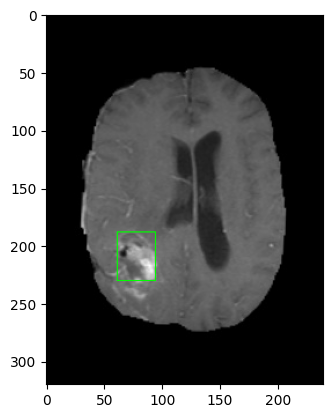

In [ ]:
img = cv2.imread(os.path.join('./axial_t1wce_2_class/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [ ]:
train_images = os.listdir('./axial_t1wce_2_class/images/train')
test_images = os.listdir('./axial_t1wce_2_class/images/test')
train_labels = os.listdir('./axial_t1wce_2_class/labels/train')
test_labels = os.listdir('./axial_t1wce_2_class/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [ ]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('./axial_t1wce_2_class/images/train', image))

In [ ]:
train_images = os.listdir('./axial_t1wce_2_class/images/train')
test_images = os.listdir('./axial_t1wce_2_class/images/test')
train_labels = os.listdir('./axial_t1wce_2_class/labels/train')
test_labels = os.listdir('./axial_t1wce_2_class/images/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [ ]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('./axial_t1wce_2_class/images/val'):
    shutil.rmtree('./axial_t1wce_2_class/images/val')
if os.path.exists('./axial_t1wce_2_class/labels/val'):
    shutil.rmtree('./axial_t1wce_2_class/labels/val')

os.mkdir('././axial_t1wce_2_class/images/val')
os.mkdir('././axial_t1wce_2_class/labels/val')

for image in val_images:
    shutil.move(os.path.join('./axial_t1wce_2_class/images/train', image), './axial_t1wce_2_class/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('./axial_t1wce_2_class/labels/train', label), './axial_t1wce_2_class/labels/val')

In [ ]:
from pathlib import Path

dataset_path = Path("./axial_t1wce_2_class")  # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*.txt"))  # all data in 'labels'

In [ ]:
print(labels)

[PosixPath('axial_t1wce_2_class/labels/test/00018_101.txt'), PosixPath('axial_t1wce_2_class/labels/test/00018_109.txt'), PosixPath('axial_t1wce_2_class/labels/test/00018_111.txt'), PosixPath('axial_t1wce_2_class/labels/test/00018_117.txt'), PosixPath('axial_t1wce_2_class/labels/test/00018_121.txt'), PosixPath('axial_t1wce_2_class/labels/test/00018_126.txt'), PosixPath('axial_t1wce_2_class/labels/test/00018_134.txt'), PosixPath('axial_t1wce_2_class/labels/test/00019_66.txt'), PosixPath('axial_t1wce_2_class/labels/test/00019_75.txt'), PosixPath('axial_t1wce_2_class/labels/test/00019_84.txt'), PosixPath('axial_t1wce_2_class/labels/test/00019_85.txt'), PosixPath('axial_t1wce_2_class/labels/test/00021_53.txt'), PosixPath('axial_t1wce_2_class/labels/test/00022_73.txt'), PosixPath('axial_t1wce_2_class/labels/test/00022_75.txt'), PosixPath('axial_t1wce_2_class/labels/test/00022_77.txt'), PosixPath('axial_t1wce_2_class/labels/test/00022_79.txt'), PosixPath('axial_t1wce_2_class/labels/test/00022

In [ ]:
text ="""
path: ../axial_t1wce_2_class
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""

with open('./fixed_path.yaml', 'w') as file:
    file.write(text)

In [ ]:
import yaml
yaml_file = "./fixed_path.yaml"  # your data YAML with data directories and names dictionary
with open(yaml_file, "r", encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(classes)

In [ ]:
import pathlib
import pandas as pd

indx = [pathlib.Path(label).stem for label in labels]  # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
from collections import Counter

for label in labels:
    lbl_counter = Counter()

    with open(label, "r") as lf:
        lines = lf.readlines()

    for line in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(line.split(" ")[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0)  # replace `nan` values with `0.0`

In [ ]:
labels_df

,negative,positive
00018_101,0.0,0.0
00018_109,0.0,0.0
00018_111,0.0,0.0
00018_117,0.0,0.0
00018_121,0.0,0.0
...,...,...
00352_103,0.0,0.0
00359_103,0.0,0.0
00359_109,0.0,0.0
00359_116,0.0,0.0


In [ ]:
from sklearn.model_selection import KFold

ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)  # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"split_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"split_{idx}"].loc[labels_df.iloc[val].index] = "val"

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1e-7)
    fold_lbl_distrb.loc[f"split_{n}"] = ratio

In [ ]:
import datetime

supported_extensions = ".jpg"

# Initialize an empty list to store image file paths
images = []

# Loop through supported extensions and gather image files
for ext in supported_extensions:
  images.extend(sorted((dataset_path / "images").rglob(f"*{ext}")))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(".." / dataset_path / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

In [ ]:
import shutil

for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
from ultralytics import YOLO

weights_path = "./yolov8n.pt"
model = YOLO(weights_path, task="detect")

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!wandb login --relogin 4703b281064fe4613044a2eda64e69d557e28906

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
results = {}

# Define your additional arguments here
project = "kfold_demo"
epochs = 50

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml, epochs=epochs, batch=-1, project=project, device=0)  # include any train arguments
    results[k] = model.metrics  # save output metrics for further analysis

Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=../axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_1/split_1_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=kfold_demo, name=train65, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fal

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.21G reserved, 0.11G allocated, 14.42G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.296          19.3         12.28        (1, 3, 640, 640)                    list
     3011238       16.39         0.308         18.91         15.25        (2, 3, 640, 640)                    list
     3011238       32.78         0.545          19.4         20.66        (4, 3, 640, 640)                    list
     3011238       65.56         1.036         27.31          29.8        (8, 3, 640, 640)                    list
     3011238       131.1         2.017         40.63         46.74       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_1/train/labels.cache... 296 images, 0 backgrounds, 0 corrupt: 100%|██████████| 296/296 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_1/val/labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to kfold_demo/train65/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to kfold_demo/train65
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.08G     0.6127     0.5405      0.877          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         75         77      0.898      0.897      0.944      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.03G     0.6563     0.6127     0.8947          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         75         77      0.901      0.883      0.941      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.03G      0.687     0.6113      0.907         10        640: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         75         77      0.874      0.906      0.948      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.03G     0.7177     0.5856     0.8911          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         75         77      0.871      0.865      0.943      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.03G     0.6711     0.6646     0.8879          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         75         77      0.779      0.946       0.92      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.03G     0.7076     0.5818     0.9156          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         75         77      0.855      0.878      0.922      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.03G     0.7137       0.58     0.8688          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         75         77      0.877      0.861      0.933      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.03G      0.763     0.7289     0.9038          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         75         77      0.778       0.76      0.837      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.03G     0.7645     0.7229     0.9474          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         75         77      0.571      0.627      0.587      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.03G     0.7376     0.6911      0.909          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         75         77      0.403      0.705      0.542      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.03G      0.722     0.6854     0.9212          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         75         77       0.75      0.854      0.828      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.03G     0.7472     0.6714     0.9328          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         75         77      0.649      0.698      0.579      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.03G     0.7927     0.7206     0.9315          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         75         77      0.839      0.751      0.854      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.03G     0.7539     0.8614     0.9298          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         75         77      0.575      0.677      0.655      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.03G      0.763     0.7704     0.9349          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         75         77      0.701      0.778      0.797      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.03G     0.7735     0.7177     0.9343          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         75         77      0.263      0.667      0.346      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.03G     0.8079     0.6654     0.9519          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         75         77      0.759      0.597      0.705       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.03G     0.8062     0.6771     0.9505          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         75         77      0.801      0.751      0.801      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.03G     0.8333     0.6505      0.945          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         75         77      0.848      0.642      0.809      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.03G     0.8307     0.7349     0.9506          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         75         77      0.745      0.805       0.82      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.03G     0.7531     0.6626     0.9132          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         75         77      0.679      0.693      0.732        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.03G     0.7645     0.6727     0.9171          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         75         77      0.667      0.645      0.596      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.03G     0.7997     0.6401     0.9477          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         75         77      0.723      0.612      0.584      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.03G     0.7652     0.6849     0.9435          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         75         77      0.818      0.745      0.854      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.03G     0.7474     0.5803     0.9122          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         75         77       0.82      0.847      0.877      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.03G     0.7467     0.5985     0.9139          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         75         77      0.715      0.794      0.781      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.03G     0.8106     0.6122     0.9636          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         75         77      0.594      0.633       0.59      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.03G     0.7872     0.6055     0.9349          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         75         77      0.679      0.825      0.819      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.03G     0.7733     0.5523      0.954          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         75         77      0.752      0.856      0.869      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.03G     0.7587     0.5183     0.9203          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         75         77      0.764      0.817      0.879      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.03G      0.778     0.5653     0.9587          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         75         77      0.877      0.909      0.922      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.03G     0.6952     0.4708     0.8946          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         75         77      0.631      0.692      0.699      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.03G     0.7303     0.7075     0.9337          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         75         77      0.792      0.855      0.896      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.03G     0.6671     0.4577     0.9174          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         75         77       0.69      0.761      0.786      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.03G     0.7056     0.5142     0.9111          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         75         77      0.834      0.809      0.885      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.03G     0.6925     0.4632      0.884          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         75         77       0.77      0.843      0.894      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.03G      0.631     0.4761     0.8738          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         75         77      0.751      0.832      0.886      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.03G     0.6154     0.4254      0.881          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         75         77      0.807      0.866      0.887      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.03G     0.6563     0.4283     0.8773          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         75         77      0.734      0.805       0.82        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.03G      0.661     0.4333     0.8696          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         75         77      0.759       0.76      0.845      0.613


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.03G      0.605     0.4877     0.8894          8        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         75         77      0.822      0.918      0.922       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.03G     0.5472     0.3836     0.8602          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         75         77      0.926      0.895      0.952      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.03G     0.5941      0.397     0.8717          8        640: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         75         77      0.857      0.917       0.94      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.03G     0.5996     0.3974     0.8672          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         75         77      0.886      0.905      0.945        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.03G     0.5913     0.3952      0.868          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         75         77      0.864       0.85      0.941      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.03G     0.5438      0.371     0.8651         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         75         77      0.958      0.902      0.966      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.03G     0.5536      0.352     0.8432          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         75         77      0.909      0.961      0.962       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.03G     0.5212      0.337     0.8649          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         75         77      0.925       0.94      0.963      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.03G      0.521     0.3437     0.8391          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         75         77      0.921      0.945       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.03G     0.5247     0.3489     0.8545          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         75         77      0.915      0.945      0.958      0.705



50 epochs completed in 0.093 hours.
Optimizer stripped from kfold_demo/train65/weights/last.pt, 6.3MB
Optimizer stripped from kfold_demo/train65/weights/best.pt, 6.2MB

Validating kfold_demo/train65/weights/best.pt...
Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


                   all         75         77      0.909      0.961      0.962      0.719
              negative         37         38      0.912      0.921      0.951      0.714
              positive         38         39      0.907          1      0.973      0.723
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to kfold_demo/train65


lr/pg0,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),██████▇▄▆▄▇▄▁▅▆▆▅▄▄▇▆▄▆▇█▅▇▆▇▇▇▆████████
metrics/mAP50-95(B),█▇▇██▇▆▄▆▃▇▄▁▅▅▆▅▃▃▆▅▃▆▆▇▅▇▆▇▇▇▆▇█▇█████
metrics/precision(B),▇▇▇▇▇▇▆▄▆▅▇▄▁▆▆▇▅▅▆▇▆▄▅▆▇▅▆▅▆▆▆▆▇█▇▇████
metrics/recall(B),▇▆▇▆▆▆▄▂▆▃▄▃▂▁▄▂▃▂▁▄▅▂▅▆▇▃▆▄▆▆▆▅▇▇▇▇▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▃▄▅▅▅▅▆▆▆▆▇▆▇▇▇█▆▆▇▆▆▇▇▇▇▅▆▄▅▃▃▄▃▂▃▃▂▂▁▁


Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=../axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_2/split_2_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=kfold_demo, name=train652, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.22G reserved, 0.10G allocated, 14.43G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.285         25.94         15.93        (1, 3, 640, 640)                    list
     3011238       16.39         0.302         22.18         17.04        (2, 3, 640, 640)                    list
     3011238       32.78         0.533         44.42         20.37        (4, 3, 640, 640)                    list
     3011238       65.56         1.028         31.41         30.55        (8, 3, 640, 640)                    list
     3011238       131.1         2.005         41.83          48.3       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_2/train/labels... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 449.94it/s]

train: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_2/val/labels... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<00:00, 434.63it/s]

val: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_2/val/labels.cache


Plotting labels to kfold_demo/train652/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to kfold_demo/train652
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.08G     0.6437     0.4233     0.8962          9        640: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         74         78      0.996          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.04G     0.6248     0.4198     0.8985         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         74         78      0.997          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.04G     0.6643     0.5308     0.9072         10        640: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         74         78      0.998          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.04G     0.7068     0.4136     0.8997          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         74         78      0.997          1      0.995      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.04G     0.6849     0.4731     0.9023          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         74         78      0.996          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.04G      0.657     0.4175     0.8954         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         74         78      0.971          1      0.995      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.04G     0.7774     0.4492     0.9311          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         74         78      0.951       0.96      0.994      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.04G     0.7455      0.475     0.9109          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         74         78      0.958       0.98      0.994      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.04G     0.7263     0.4554     0.9048          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         74         78      0.923      0.965      0.991      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.04G     0.7071     0.4711     0.8997          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         74         78      0.834      0.917      0.928      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.04G     0.7106     0.5268     0.8894         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         74         78      0.985          1      0.991      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.04G     0.6774     0.4718     0.8915         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         74         78      0.719      0.845      0.863       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.04G     0.6916     0.4452     0.9131          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         74         78      0.833      0.639      0.796      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.04G     0.7021     0.4643     0.9049         11        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         74         78      0.862       0.85      0.902      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.04G     0.7287     0.4919     0.9214          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         74         78      0.757      0.732      0.773       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.04G     0.7113     0.5109     0.9109         10        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         74         78      0.846      0.922      0.938      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.04G     0.7289      0.545      0.931          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         74         78      0.955      0.986       0.99      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.04G     0.7337      0.524     0.9139         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         74         78      0.785      0.888      0.834       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.04G     0.7167     0.6555     0.9129          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         74         78      0.714      0.681      0.708      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.04G     0.7531     0.5621     0.9223          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         74         78      0.747       0.73      0.795      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.04G     0.8307     0.6085     0.9354          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         74         78      0.858      0.778       0.84      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.04G      0.807     0.6146     0.9607          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         74         78      0.613      0.643       0.75      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.04G     0.6998     0.5365     0.9039         11        640: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         74         78      0.647      0.584       0.63      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.04G     0.7043     0.4891     0.8964          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         74         78      0.657       0.78      0.858      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.04G     0.7293     0.4885     0.9048          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         74         78      0.652      0.783       0.84      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.04G     0.7354     0.4976     0.9168          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         74         78      0.838      0.883      0.955      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.04G     0.7212     0.4693      0.933          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         74         78      0.989      0.929      0.991      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.04G      0.685     0.4416      0.906         10        640: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         74         78      0.969      0.958      0.984       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.04G     0.6788     0.4401     0.9102         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         74         78       0.96      0.917       0.97      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.04G     0.7402     0.4518     0.9112          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         74         78      0.964      0.932      0.978      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.04G      0.642     0.4994     0.8876         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         74         78      0.984      0.979      0.994      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.04G     0.6229     0.4175     0.8947          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         74         78      0.959      0.908      0.982      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.04G      0.639     0.3972     0.8962         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         74         78      0.977      0.932      0.988      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.04G     0.6327     0.3904     0.8641          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         74         78      0.956      0.981      0.992      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.04G     0.6095     0.3952     0.8639          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         74         78      0.954      0.924       0.99      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.04G     0.6334     0.3685     0.8858          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         74         78      0.976       0.98      0.991       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.04G     0.5668     0.3522     0.8508          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         74         78      0.997       0.99      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.04G     0.5913     0.3655     0.8706          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         74         78      0.892      0.886      0.941       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.04G     0.6073     0.3565     0.8554          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         74         78      0.983      0.962      0.991      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.04G     0.5879     0.3566     0.8664         10        640: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         74         78      0.935      0.998      0.991      0.817


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.04G     0.5749     0.3505     0.8585          9        640: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all         74         78      0.955      0.988       0.99      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.04G     0.5638     0.3478     0.8392          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         74         78      0.956      0.994      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.04G     0.5485     0.3256     0.8528         11        640: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         74         78      0.985      0.988      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.04G     0.5229     0.3287     0.8323          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         74         78      0.983      0.988      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.04G     0.5004     0.3449     0.8492          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         74         78      0.988      0.985      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.04G     0.5003     0.3031     0.8347          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         74         78      0.967      0.989      0.993      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.04G     0.5209     0.3081     0.8286         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         74         78      0.984      0.979      0.993      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.04G     0.4958     0.3029     0.8295          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         74         78      0.983      0.976      0.993      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.04G     0.4714     0.2889     0.8398          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         74         78      0.986      0.976      0.993      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.04G     0.4977     0.3023     0.8248         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         74         78       0.99      0.976      0.993      0.846



50 epochs completed in 0.096 hours.
Optimizer stripped from kfold_demo/train652/weights/last.pt, 6.3MB
Optimizer stripped from kfold_demo/train652/weights/best.pt, 6.2MB

Validating kfold_demo/train652/weights/best.pt...
Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


                   all         74         78      0.997          1      0.995      0.907
              negative         46         49      0.997          1      0.995      0.913
              positive         28         29      0.996          1      0.995      0.901
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to kfold_demo/train652


lr/pg0,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),█████████▅▄▆▇█▅▂▅▃▁▅▇█████████▇█████████
metrics/mAP50-95(B),████▇▇▇▇▇▄▄▅▅▇▄▂▃▂▁▅▆▆▆▆▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇█
metrics/precision(B),█████▇▇▇█▃▅▆▅▇▄▃▅▁▂▂▅█▇▇█▇█▇██▆█▇▇██▇███
metrics/recall(B),█████▇█▇█▅▂▅▇█▆▃▄▂▁▄▆▇▇▇█▆▇███▆▇████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▄▄▅▅▄▇▆▆▅▅▅▅▆▆▆▆██▅▅▆▆▅▅▄▄▄▄▄▂▃▃▃▂▂▂▁▂▁▁


Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=../axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_3/split_3_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=kfold_demo, name=train6522, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.22G reserved, 0.11G allocated, 14.41G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.298         30.96         19.51        (1, 3, 640, 640)                    list
     3011238       16.39         0.306         23.25         17.12        (2, 3, 640, 640)                    list
     3011238       32.78         0.539         21.38         20.85        (4, 3, 640, 640)                    list
     3011238       65.56         1.036         24.34         28.31        (8, 3, 640, 640)                    list
     3011238       131.1         2.015            38         45.15       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_3/train/labels... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 1606.61it/s]

train: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_3/val/labels... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<00:00, 812.30it/s]

val: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_3/val/labels.cache


Plotting labels to kfold_demo/train6522/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to kfold_demo/train6522
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.07G     0.6493      0.421     0.8774          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         74         79      0.994          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.04G     0.6886     0.4071      0.894          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         74         79      0.997          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.04G     0.6387     0.5066     0.8989          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         74         79      0.996          1      0.995      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.04G     0.6563     0.3923     0.8897         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         74         79      0.983      0.991      0.994      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.04G     0.6588     0.4138     0.8963          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         74         79      0.993       0.99      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.04G     0.6535      0.428     0.9146          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         74         79      0.979          1      0.994      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.04G     0.6892     0.4384     0.9019          9        640: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         74         79      0.944          1      0.994      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.04G     0.6854     0.4644     0.8904         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         74         79      0.944      0.943      0.986      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.04G     0.6486      0.456     0.8609          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         74         79      0.939      0.962      0.982      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.04G     0.6698     0.5346     0.8856          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         74         79      0.978      0.971      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.04G     0.6516     0.4899      0.893         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         74         79      0.933      0.975      0.988      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.04G     0.6882     0.4509     0.8916         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         74         79       0.96      0.982      0.992      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.04G     0.6829     0.4675     0.8931          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         74         79          1      0.974      0.995      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.04G     0.7226     0.4611      0.902         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         74         79      0.912      0.943      0.966      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.04G     0.7255     0.4801        0.9         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         74         79       0.95      0.899      0.972      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.04G     0.7217     0.4796     0.9059          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         74         79      0.914      0.901      0.956      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.04G     0.6614     0.4547     0.9157          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         74         79      0.832      0.836      0.904      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.04G     0.7701      0.502     0.9264         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         74         79      0.868      0.766      0.907      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.04G     0.7886     0.5315     0.9174          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         74         79      0.827      0.894      0.931      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.04G     0.7268     0.4678     0.8987          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         74         79       0.92      0.898      0.957      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.04G     0.7481     0.4903     0.9028         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         74         79      0.842      0.806      0.908      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.04G     0.7227      0.508     0.9052          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         74         79        0.8      0.836      0.893      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.04G     0.7602     0.5767     0.9213         10        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         74         79       0.76       0.79       0.76      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.04G     0.7671     0.5359     0.9339          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         74         79      0.849      0.862       0.91      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.04G     0.7102     0.5165     0.9048          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         74         79      0.886      0.829      0.896      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.04G     0.6667     0.4607     0.8727          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         74         79      0.829      0.765      0.834      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.04G     0.7294     0.4717     0.9217          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         74         79      0.873      0.808      0.874      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.04G     0.6524     0.4131     0.8817          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         74         79      0.918      0.782      0.891        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.04G     0.7049     0.5132     0.8995         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         74         79      0.822       0.74      0.816       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.04G      0.651     0.4511      0.887          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         74         79      0.838      0.785      0.883      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.04G     0.6357     0.4252     0.8645         10        640: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         74         79      0.915      0.853      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.04G      0.653     0.4513     0.8867          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         74         79       0.88      0.957      0.979      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.04G     0.6169     0.3744     0.8706          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         74         79      0.953      0.929      0.979      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.04G     0.6269     0.4063     0.8719          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         74         79      0.961      0.963      0.976      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.04G     0.6244     0.3813     0.8609          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         74         79      0.948      0.909      0.971        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.04G     0.5924      0.368     0.8609          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         74         79      0.861      0.977      0.975      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.04G     0.5993     0.3673     0.8555         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         74         79      0.871      0.953      0.972      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.04G      0.611     0.3631     0.8984          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         74         79       0.91      0.921      0.971      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.04G      0.569     0.3495     0.8539          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         74         79      0.953      0.878      0.967      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.04G     0.6114     0.4019       0.85          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         74         79      0.973      0.957      0.982      0.799


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.04G      0.562      0.359     0.8628          9        640: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         74         79       0.97      0.981       0.99       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.04G     0.6073      0.351     0.8565          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         74         79      0.965      0.971      0.991       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.04G     0.5299     0.3327      0.841         12        640: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         74         79      0.975      0.971      0.992      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.04G     0.5179     0.3227     0.8546          9        640: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         74         79      0.978       0.98      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.04G     0.4955     0.3413     0.8324         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         74         79      0.996      0.981      0.995      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.04G     0.5002     0.3066     0.8414          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         74         79      0.998      0.981      0.995       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.04G     0.4937      0.298     0.8423          9        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         74         79      0.997      0.981      0.995       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.04G     0.4942     0.3097     0.8338          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         74         79      0.978       0.98      0.994      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.04G     0.5016     0.3066     0.8257         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         74         79      0.979      0.978      0.994      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.04G     0.4583     0.2857     0.8224          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         74         79      0.979      0.975      0.994      0.841



50 epochs completed in 0.101 hours.
Optimizer stripped from kfold_demo/train6522/weights/last.pt, 6.3MB
Optimizer stripped from kfold_demo/train6522/weights/best.pt, 6.2MB

Validating kfold_demo/train6522/weights/best.pt...
Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


                   all         74         79      0.994          1      0.995      0.901
              negative         48         51      0.988          1      0.995      0.915
              positive         26         28          1      0.999      0.995      0.887
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to kfold_demo/train6522


lr/pg0,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),███████████▇▇▅▅▆▅▅▁▅▃▄▅▃▆██▇▇▇▇▇████████
metrics/mAP50-95(B),███▇▇▇▇▇▆▇▇▅▅▄▄▄▄▄▁▄▂▄▄▂▄▅▅▆▅▆▅▅▆▆▆▆▆▆▇█
metrics/precision(B),████▇▆▆▆▆▇█▅▅▃▄▃▃▂▁▄▃▄▆▃▆▅▇▇▄▄▅▇▇▇▇▇██▇█
metrics/recall(B),██████▆▇▇█▇▆▅▄▂▅▃▄▂▄▂▃▂▁▄▇▆▇▇▇▆▅▇▇▇▇▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▅▆▅▅▅▆▆▅▅▆▆▇▇▅██▇▇▇█▅▇▅▆▅▅▄▅▄▄▄▃▃▄▃▂▂▂▂▁


Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=../axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_4/split_4_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=kfold_demo, name=train65222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.22G reserved, 0.11G allocated, 14.41G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.298         21.39         13.71        (1, 3, 640, 640)                    list
     3011238       16.39         0.304            43         25.63        (2, 3, 640, 640)                    list
     3011238       32.78         0.537         29.77         29.31        (4, 3, 640, 640)                    list
     3011238       65.56         1.042         29.79         31.42        (8, 3, 640, 640)                    list
     3011238       131.1         2.020         40.54         47.55       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_4/train/labels... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 1159.19it/s]

train: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_4/val/labels... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<00:00, 597.11it/s]

val: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_4/val/labels.cache


Plotting labels to kfold_demo/train65222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005546875000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to kfold_demo/train65222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.18G      0.611     0.4313       0.89         13        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all         74         76      0.995      0.995      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.83G     0.6138     0.4015     0.8933         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         74         76      0.982          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.83G     0.6174     0.5127      0.866         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         74         76      0.994          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.83G     0.6395     0.4276     0.8771         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         74         76          1      0.974      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.83G     0.6586     0.4647     0.8946         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         74         76      0.967      0.982      0.991      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.83G     0.6383     0.4105     0.8795         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         74         76      0.985      0.986      0.994      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.83G     0.6061     0.4023      0.862         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         74         76      0.948      0.978       0.99      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.83G       0.69     0.4307      0.897         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         74         76      0.886      0.883       0.96      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.83G     0.6779     0.4606     0.8971         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         74         76       0.95      0.924      0.989      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.83G     0.6731     0.4591     0.8956         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         74         76      0.974      0.976      0.993      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.83G     0.7022      0.492     0.9176         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         74         76      0.797      0.866      0.881      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.83G     0.6665     0.4949     0.9026         14        640: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         74         76      0.796      0.816      0.855      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.83G     0.7178     0.4966     0.9026         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         74         76      0.675      0.703      0.771      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.83G     0.7116     0.5523     0.9152         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         74         76      0.857      0.889      0.919      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.83G     0.6759     0.4697     0.8799         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         74         76      0.847      0.813      0.869      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.83G     0.6914     0.4577     0.8776         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         74         76       0.74      0.847      0.873      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.83G     0.6915     0.4773     0.8934         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         74         76      0.847      0.839      0.916      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.83G      0.732     0.4828     0.9285         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         74         76      0.768      0.905      0.906      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.83G     0.7373     0.5529     0.9304         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         74         76      0.802      0.904      0.951      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.83G     0.7436     0.5658     0.9321         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         74         76      0.655       0.76      0.758      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.83G     0.7069     0.4753     0.8924         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         74         76      0.563      0.635      0.497      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.83G     0.7821     0.5272     0.9253         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         74         76      0.816      0.731      0.856       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.83G     0.7785     0.5303     0.9258         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         74         76      0.698      0.774      0.787      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.83G     0.7117     0.5009     0.8998         14        640: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         74         76      0.709      0.769      0.826      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.83G     0.7085     0.4609     0.8962         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         74         76      0.843      0.904      0.964      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.83G     0.7345     0.4619      0.903         15        640: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         74         76      0.804      0.852      0.962      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.83G     0.6884     0.4684     0.8967         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         74         76      0.791      0.837      0.933      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.83G     0.6551     0.4452       0.89         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         74         76       0.96      0.972      0.989      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.83G     0.7409     0.4528     0.9322         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         74         76      0.965      0.939      0.986      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.83G     0.6591     0.4128     0.8959         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         74         76      0.969      0.841      0.953      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.83G      0.664     0.4244     0.8771         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         74         76      0.735      0.841      0.872      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.83G     0.6412     0.4008     0.8814         16        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         74         76        0.7      0.752      0.789       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.83G     0.6271     0.4061     0.8788         15        640: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         74         76      0.865       0.96      0.962      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.83G     0.6378     0.3964      0.863         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         74         76       0.92      0.961      0.983      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.83G     0.6165     0.3775     0.8783         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         74         76      0.959       0.95      0.971      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.83G     0.5939     0.3691     0.8698         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         74         76      0.825      0.824      0.929      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.83G     0.5809     0.3835     0.8488         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         74         76      0.873      0.911      0.967      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.83G     0.5808     0.3958      0.857         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         74         76       0.95       0.97      0.984      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.83G     0.5746     0.3511      0.857         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         74         76      0.937      0.969      0.984      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.83G     0.5949     0.3764     0.8509         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         74         76      0.945      0.934      0.979      0.839


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.83G     0.5512     0.3262     0.8506         13        640: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         74         76      0.935      0.955      0.986      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.83G     0.5462     0.3265     0.8577         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         74         76      0.941      0.988      0.992      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.83G     0.5308      0.321     0.8468         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         74         76      0.945      0.988      0.988      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.83G      0.572     0.3509     0.8703         16        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         74         76      0.947      0.963      0.988       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.83G     0.5596     0.3212     0.8412         14        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         74         76      0.946      0.961      0.987      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.83G     0.4918     0.3062     0.8467         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         74         76      0.974      0.971       0.99      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.83G     0.5113     0.3062     0.8298         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         74         76      0.971      0.965      0.991      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.83G     0.5242      0.296     0.8268         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         74         76       0.97      0.977      0.992      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.83G      0.471     0.2835     0.8282         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         74         76      0.971      0.978      0.993      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.83G     0.4337     0.2702     0.8136         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         74         76      0.971      0.981      0.994      0.861



50 epochs completed in 0.103 hours.
Optimizer stripped from kfold_demo/train65222/weights/last.pt, 6.3MB
Optimizer stripped from kfold_demo/train65222/weights/best.pt, 6.2MB

Validating kfold_demo/train65222/weights/best.pt...
Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


                   all         74         76      0.995      0.994      0.995       0.91
              negative         36         36      0.989          1      0.995      0.929
              positive         38         40          1      0.988      0.995      0.891
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to kfold_demo/train65222


lr/pg0,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),████████▆▆▅▇▆▇▇▇▁▆▅▆█▇██▆▅██▇███████████
metrics/mAP50-95(B),█████▇▇▇▆▅▄▆▆▆▅▆▁▄▄▅▆▆▇▇▅▄▆▇▆▇▇▇▇▇▇▇▇▇▇█
metrics/precision(B),█████▇▆▇▅▅▃▆▄▆▄▅▁▅▃▃▅▅▇▇▄▃▆▇▅▆▇▇▇▇▇▇████
metrics/recall(B),██████▆▇▅▄▂▆▅▅▆▆▁▃▄▄▅▅▇▇▅▃▇▇▅▆▇▇▇██▇▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▅▅▅▅▅▄▆▆▆▆▇▇▆▆▇▇▆██▇▇▆▅▇▆▅▅▅▄▄▄▄▃▃▃▄▂▃▃▁


Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=../axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_5/split_5_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=kfold_demo, name=train652222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.21G reserved, 0.11G allocated, 14.42G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.285          29.2         20.18        (1, 3, 640, 640)                    list
     3011238       16.39         0.308         22.12         16.34        (2, 3, 640, 640)                    list
     3011238       32.78         0.541         19.97         20.38        (4, 3, 640, 640)                    list
     3011238       65.56         1.044         29.78         33.26        (8, 3, 640, 640)                    list
     3011238       131.1         2.024         40.21         46.92       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_5/train/labels... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 498.35it/s]

train: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_5/val/labels... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<00:00, 418.53it/s]

val: New cache created: /content/axial_t1wce_2_class/2024-09-11_5-Fold_Cross-val/split_5/val/labels.cache


Plotting labels to kfold_demo/train652222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005546875000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to kfold_demo/train652222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.18G     0.6123     0.4035     0.8936         14        640: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         74         80      0.997          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.83G      0.607     0.3833     0.8624         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         74         80      0.986          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.83G     0.6438      0.483     0.9139         14        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         74         80       0.96      0.991      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.83G     0.6411     0.4035     0.8868         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         74         80      0.997          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.83G     0.6411     0.4463     0.8864         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         74         80      0.989          1      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.83G     0.7017     0.4699     0.8902         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         74         80      0.991      0.991      0.995      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.83G     0.6394     0.4418     0.8841         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         74         80      0.976      0.996      0.995      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.83G     0.6548     0.4367     0.8992         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         74         80      0.976      0.999      0.995      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.83G     0.7193     0.4296     0.9058         13        640: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         74         80      0.985      0.967      0.992      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.83G     0.7769     0.5154     0.9115         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         74         80      0.754      0.903      0.881      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.83G     0.7118     0.5098      0.925         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         74         80      0.979       0.91      0.984      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.83G     0.6687     0.4791     0.9028         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         74         80      0.881       0.85      0.952      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.83G      0.662     0.4554     0.8788         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         74         80      0.938      0.861      0.938       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.83G     0.6809     0.4418     0.9036         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         74         80      0.821      0.616      0.609      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.83G     0.7342     0.4867     0.9022         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         74         80      0.801      0.751      0.762      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.83G     0.6836     0.4653     0.8917         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         74         80      0.847      0.859      0.865      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.83G     0.7776     0.4615     0.9442         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         74         80      0.747      0.857      0.896      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.83G     0.7355     0.4577     0.9211         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         74         80      0.846      0.849      0.908      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.83G     0.7124     0.4806     0.9225         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         74         80      0.546      0.754      0.665       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.83G     0.7385     0.4731     0.9248         14        640: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         74         80      0.876      0.918      0.927      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.83G     0.7348     0.5709     0.9008         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         74         80       0.52      0.857      0.704      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.83G     0.6704     0.5207     0.8951         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         74         80      0.547      0.722      0.572      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.83G     0.7121     0.5348     0.9078         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         74         80      0.656      0.646      0.486      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.83G     0.7388     0.5505     0.9154         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         74         80      0.933      0.843      0.927      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.83G     0.7531      0.545     0.9196         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         74         80      0.651      0.557      0.536      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.83G     0.7176     0.5146      0.903         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         74         80      0.884      0.785      0.926      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.83G     0.7734     0.5424     0.9191         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         74         80      0.828      0.866      0.875      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.83G     0.7358     0.4866     0.9134         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         74         80      0.709       0.87      0.813      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.83G     0.7074     0.4669     0.9083         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         74         80      0.732        0.7      0.706      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.83G     0.7145     0.4637     0.9074         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         74         80      0.744      0.817      0.819      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.83G     0.6887     0.4318     0.9039         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         74         80      0.944      0.796      0.921      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.83G     0.6799     0.4168     0.8938         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         74         80       0.92       0.92      0.974      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.83G     0.6724      0.409     0.8944         15        640: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         74         80      0.953      0.944      0.977      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.83G     0.5986      0.381     0.8741         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         74         80      0.938      0.962       0.97      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.83G     0.6228     0.3788     0.8779         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         74         80      0.933      0.964       0.97      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.83G      0.629     0.3837     0.8915         13        640: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         74         80      0.989      0.979      0.989      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.83G     0.6144      0.368      0.884         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         74         80      0.928      0.954      0.965      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.83G     0.6172     0.3933     0.8848         13        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         74         80      0.913      0.953       0.96      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.83G     0.5955     0.3743     0.8617         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         74         80      0.972       0.94      0.976      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.83G     0.6232     0.3957      0.853         16        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         74         80      0.962      0.982      0.987       0.79


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.83G     0.5821     0.3553      0.849         14        640: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all         74         80      0.953       0.95      0.979        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.83G     0.5539     0.3357     0.8488         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         74         80      0.968      0.897       0.98      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.83G     0.5404     0.3234     0.8446         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         74         80      0.982      0.913      0.985      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.83G     0.5646     0.3363     0.8812         13        640: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         74         80      0.983      0.924      0.982      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.83G     0.5445     0.3259      0.851         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         74         80      0.961      0.906      0.984      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.83G     0.5248     0.3203     0.8372         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         74         80      0.965      0.972      0.989      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.83G     0.5059     0.3033     0.8431         13        640: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         74         80       0.95      0.963      0.988      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.83G       0.49     0.2964     0.8336         13        640: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         74         80      0.978      0.989      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.83G     0.5062      0.299     0.8497         15        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         74         80      0.975      0.994      0.993      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.83G     0.4745     0.2806     0.8271         14        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         74         80      0.971       0.99      0.993      0.843



50 epochs completed in 0.110 hours.
Optimizer stripped from kfold_demo/train652222/weights/last.pt, 6.3MB
Optimizer stripped from kfold_demo/train652222/weights/best.pt, 6.2MB

Validating kfold_demo/train652222/weights/best.pt...
Ultralytics YOLOv8.2.91 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


                   all         74         80      0.997          1      0.995      0.905
              negative         30         30      0.999          1      0.995      0.897
              positive         44         50      0.994          1      0.995      0.912
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to kfold_demo/train652222


lr/pg0,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),█████████▇▇▃▆▇▇▃▄▂▁▇▇▆▆▄▇███████████████
metrics/mAP50-95(B),█████▇▇▇▇▆▆▃▅▅▆▃▃▂▁▅▆▅▄▄▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
metrics/precision(B),██▇██████▆▇▅▆▄▆▁▁▁▃▇▆▆▄▄▇▇▇▇█▇▇█▇████▇██
metrics/recall(B),███████▇▆▅▅▁▅▅▅▄▅▃▂▅▄▆▆▃▄▇▇▇█▇▇▇▇▆▆▇▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▄▄▅▅▆▅▅▇▆▅▅▆▆█▇▆▇▆▆▇▇█▇▆▆▆▆▄▅▄▄▄▃▃▃▃▂▂▁▁


In [ ]:
#early_stopping = EarlyStopping()
#results = model.train(data='./fixed_path.yaml', batch=-1, epochs=50, device=0)

Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./fixed_path.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 18.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/axial_t1wce_2_class/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 557.57it/s]

train: New cache created: /content/axial_t1wce_2_class/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 663.72it/s]

val: New cache created: /content/axial_t1wce_2_class/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       9.4G      1.681      4.546      1.471         48        640: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

                   all         59         60   0.000808      0.218    0.00103   0.000613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.31G      1.657      4.515       1.45         43        640: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         59         60    0.00113      0.325    0.00185   0.000723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.33G      1.682      4.591      1.485         37        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all         59         60    0.00112      0.282    0.00219   0.000843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.33G      1.346      3.839      1.225         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         59         60    0.00215      0.675      0.197       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.33G      1.252      3.103      1.126         35        640: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         59         60    0.00264      0.766      0.236      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.33G      1.142        2.5      1.069         47        640: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         59         60     0.0013      0.417      0.193      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.39G      1.118      2.322       1.07         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         59         60     0.0012      0.377       0.13     0.0704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.39G      1.095      2.287      1.043         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         59         60    0.00268      0.794        0.3      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.33G      1.143      2.177      1.062         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         59         60    0.00307      0.937      0.237      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.33G      1.149      2.196      1.072         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         59         60    0.00296      0.901      0.201      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.33G      1.061      1.927      1.025         35        640: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         59         60      0.791     0.0278     0.0938     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.33G      1.008      1.844      1.005         48        640: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         59         60    0.00142      0.425     0.0298     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.33G      1.022      1.904      1.015         33        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         59         60       0.81     0.0278     0.0294     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.33G      0.993      1.719      1.018         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         59         60      0.761     0.0278     0.0926     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.33G      1.072      1.759      1.046         33        640: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         59         60       0.99      0.111      0.404      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.33G      1.023      1.623      1.038         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         59         60      0.804     0.0278      0.226      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.33G      1.003      1.539      1.024         44        640: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         59         60     0.0021      0.563      0.348      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.33G      1.012      1.515      1.004         31        640: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         59         60    0.00171      0.429      0.109     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.33G     0.9813      1.389      1.031         37        640: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         59         60    0.00163      0.492     0.0563     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.33G       1.01      1.503      1.031         40        640: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         59         60      0.457      0.163      0.111     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.33G      1.052      1.451      1.064         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         59         60      0.845      0.153       0.34      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.33G      1.045      1.434      1.045         32        640: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         59         60      0.609       0.13      0.263      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.33G      1.052      1.408       1.05         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         59         60      0.612       0.19      0.194      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.33G      1.027      1.437      1.063         32        640: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         59         60      0.506      0.407      0.347      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.33G     0.9454      1.245      1.018         34        640: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         59         60        0.7      0.168      0.296      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.33G     0.9345      1.153     0.9991         31        640: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         59         60      0.495      0.302      0.264      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.33G      1.015      1.213      1.024         41        640: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         59         60      0.581      0.464      0.455       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.33G     0.9786      1.117      1.017         32        640: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         59         60      0.593      0.492      0.538       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.33G     0.9481      1.072      1.009         36        640: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         59         60      0.635      0.592      0.593      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.33G     0.8839      1.028     0.9953         51        640: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         59         60      0.534       0.59      0.609      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.39G     0.9293      1.004      1.014         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         59         60      0.498      0.538      0.566      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.33G     0.9573      1.009     0.9925         38        640: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         59         60      0.546      0.783      0.608      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.33G     0.8804      0.997     0.9876         27        640: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         59         60      0.626      0.702      0.634      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.33G      0.881     0.9904     0.9992         27        640: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         59         60      0.741      0.754      0.789      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.33G     0.9232     0.8901     0.9942         35        640: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         59         60      0.629      0.818      0.745      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.33G     0.8825     0.8632     0.9899         33        640: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         59         60      0.747      0.736      0.701      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.33G     0.8598     0.8838     0.9804         37        640: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         59         60      0.744      0.801      0.797      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.33G     0.8216     0.8336     0.9816         32        640: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         59         60      0.903      0.788      0.826      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.33G      0.813     0.7891     0.9545         27        640: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         59         60      0.794       0.78      0.868      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.33G      0.816     0.7809     0.9632         41        640: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         59         60      0.839      0.821      0.844      0.614


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.33G     0.7604     0.8366      0.921         21        640: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         59         60      0.862      0.823      0.836       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.33G     0.7032     0.8267     0.9379         21        640: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         59         60      0.879       0.81      0.831      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.33G     0.6791       0.73     0.9088         21        640: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         59         60       0.84      0.806      0.799      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.33G     0.7083     0.7815     0.9236         21        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         59         60        0.9      0.853      0.888      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.33G     0.6921     0.7369     0.9227         21        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         59         60      0.847      0.905      0.933      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.33G      0.647     0.6467     0.8859         21        640: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         59         60      0.847      0.897      0.912        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.33G     0.6807     0.6597     0.9153         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         59         60      0.907      0.802      0.891      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.33G     0.6567     0.6393     0.9098         22        640: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         59         60      0.907      0.803      0.889       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.33G     0.6347     0.6159     0.8872         21        640: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         59         60      0.879      0.842      0.904      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.33G     0.5911     0.6181     0.8881         23        640: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         59         60      0.881      0.861      0.916      0.683



50 epochs completed in 0.076 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


                   all         59         60      0.852      0.897      0.912        0.7
              negative         18         18      0.779      0.889      0.885      0.733
              positive         41         42      0.926      0.905      0.939      0.667
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


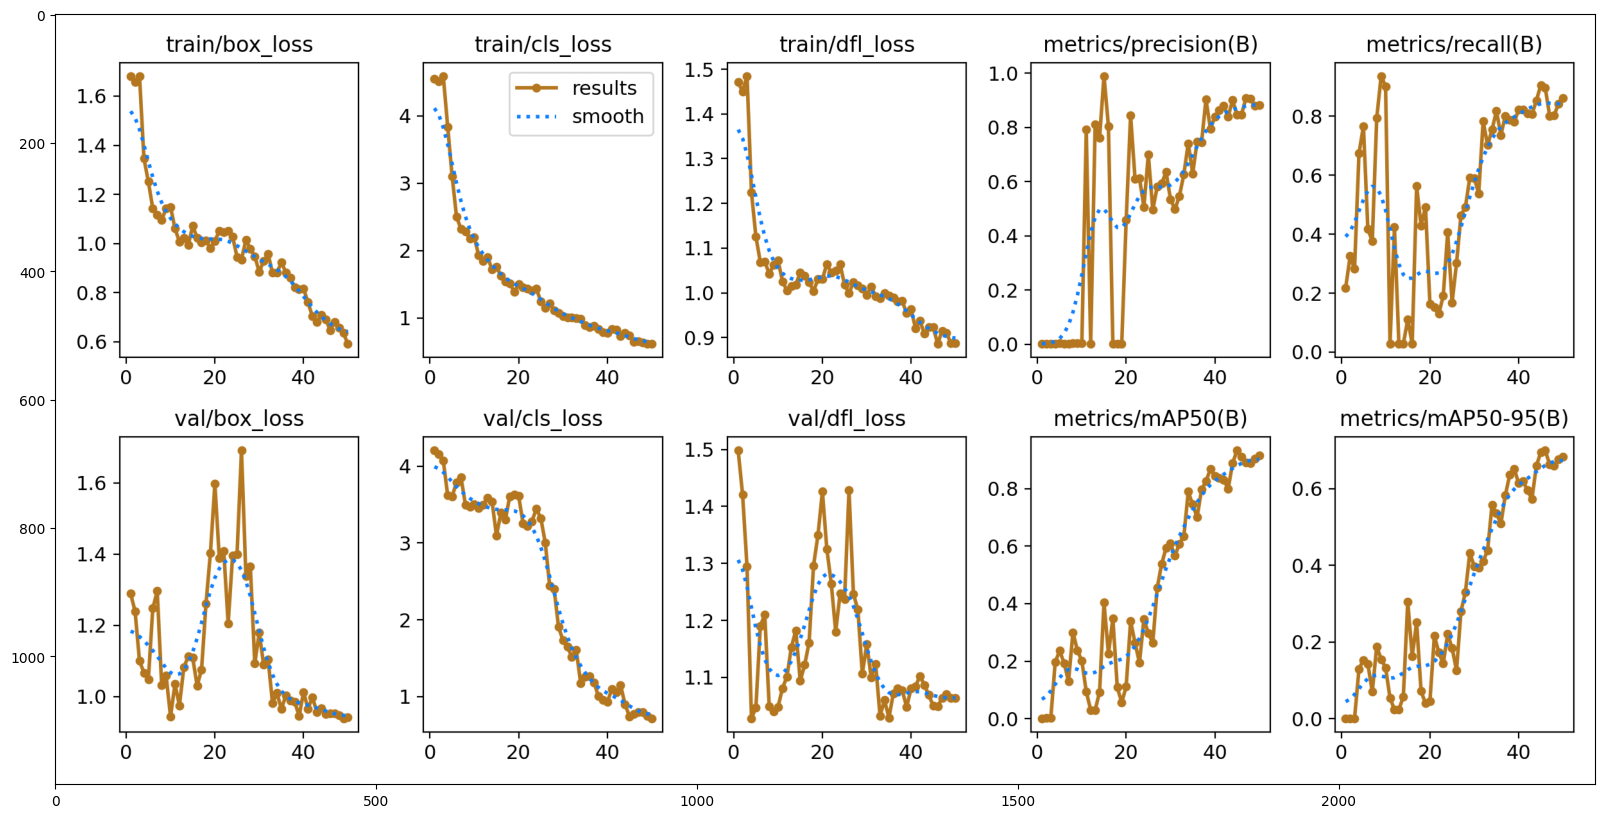

In [ ]:
training_save_dir = './' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

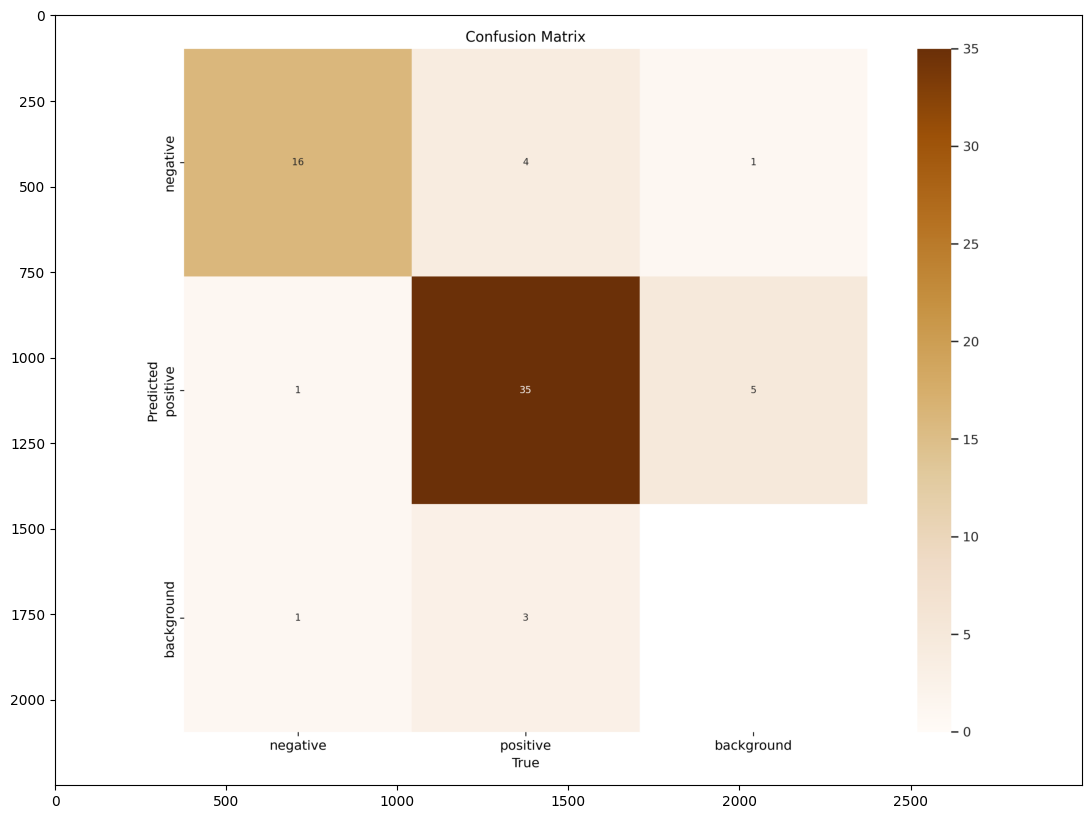

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

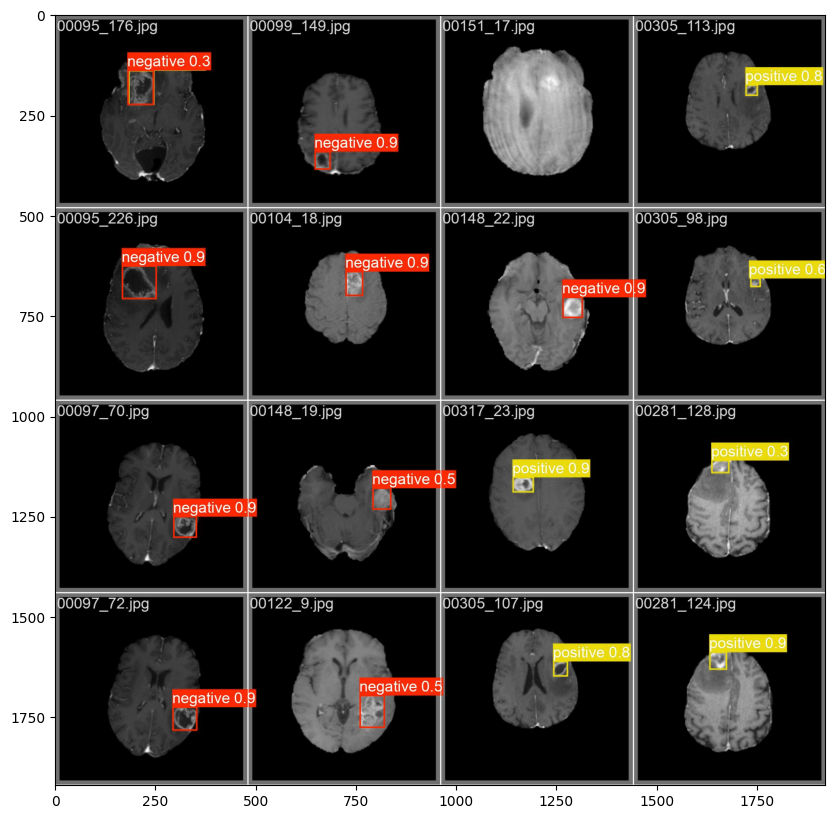

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

In [ ]:
from sahi.predict import predict
predictions = predict(
    source="./axial_t1wce_2_class/images/test",
    model_type = "yolov8",
    model_path = training_save_dir + '/weights/best.pt',
    model_confidence_threshold=0.4,
    model_device='cuda:0',
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    )

There are 75 listed files in folder: test/


Performing inference on images:   1%|▏         | 1/75 [00:00<00:09,  7.41it/s]

Performing prediction on 1 slices.
Prediction time is: 122.75 ms
Performing prediction on 1 slices.


Performing inference on images:   1%|▏         | 1/75 [00:00<00:09,  7.41it/s]

Prediction time is: 20.81 ms
Performing prediction on 1 slices.
Prediction time is: 19.18 ms
Performing prediction on 1 slices.


Performing inference on images:   7%|▋         | 5/75 [00:00<00:03, 22.06it/s]

Prediction time is: 19.64 ms
Performing prediction on 1 slices.
Prediction time is: 18.83 ms
Performing prediction on 1 slices.
Prediction time is: 17.98 ms
Performing prediction on 1 slices.
Prediction time is: 38.07 ms
Performing prediction on 9 slices.


Performing inference on images:  15%|█▍        | 11/75 [00:00<00:03, 19.26it/s]

Prediction time is: 146.05 ms
Performing prediction on 1 slices.
Prediction time is: 22.94 ms
Performing prediction on 1 slices.
Prediction time is: 24.62 ms
Performing prediction on 1 slices.
Prediction time is: 23.67 ms
Performing prediction on 9 slices.


Performing inference on images:  15%|█▍        | 11/75 [00:00<00:03, 19.26it/s]

Prediction time is: 184.84 ms
Performing prediction on 9 slices.
Prediction time is: 156.77 ms
Performing prediction on 1 slices.


Performing inference on images:  24%|██▍       | 18/75 [00:01<00:03, 16.04it/s]

Prediction time is: 21.02 ms
Performing prediction on 1 slices.
Prediction time is: 20.99 ms
Performing prediction on 1 slices.
Prediction time is: 24.53 ms
Performing prediction on 1 slices.
Prediction time is: 18.59 ms
Performing prediction on 1 slices.
Prediction time is: 20.64 ms
Performing prediction on 1 slices.
Prediction time is: 20.51 ms
Performing prediction on 9 slices.


Performing inference on images:  33%|███▎      | 25/75 [00:01<00:02, 19.12it/s]

Prediction time is: 143.75 ms
Performing prediction on 1 slices.
Prediction time is: 19.64 ms
Performing prediction on 1 slices.
Prediction time is: 19.31 ms
Performing prediction on 1 slices.
Prediction time is: 18.89 ms
Performing prediction on 1 slices.
Prediction time is: 20.39 ms
Performing prediction on 1 slices.
Prediction time is: 17.30 ms
Performing prediction on 9 slices.


Performing inference on images:  33%|███▎      | 25/75 [00:01<00:02, 19.12it/s]

Prediction time is: 192.25 ms
Performing prediction on 1 slices.
Prediction time is: 25.34 ms
Performing prediction on 9 slices.


Performing inference on images:  37%|███▋      | 28/75 [00:02<00:03, 12.08it/s]

Prediction time is: 209.42 ms
Performing prediction on 1 slices.
Prediction time is: 37.13 ms
Performing prediction on 9 slices.


Performing inference on images:  40%|████      | 30/75 [00:02<00:04, 10.21it/s]

Prediction time is: 229.79 ms
Performing prediction on 1 slices.
Prediction time is: 25.67 ms
Performing prediction on 1 slices.
Prediction time is: 25.34 ms
Performing prediction on 9 slices.


Performing inference on images:  44%|████▍     | 33/75 [00:02<00:04,  9.65it/s]

Prediction time is: 241.13 ms
Performing prediction on 9 slices.


Prediction time is: 204.15 ms
Performing prediction on 1 slices.
Prediction time is: 23.62 ms
Performing prediction on 1 slices.
Prediction time is: 22.41 ms
Performing prediction on 1 slices.
Prediction time is: 23.87 ms
Performing prediction on 1 slices.
Prediction time is: 25.81 ms
Performing prediction on 1 slices.
Prediction time is: 24.42 ms


Performing inference on images:  51%|█████     | 38/75 [00:03<00:03, 11.66it/s]

Performing prediction on 1 slices.
Prediction time is: 30.39 ms
Performing prediction on 9 slices.


Performing inference on images:  55%|█████▍    | 41/75 [00:03<00:03, 10.72it/s]

Prediction time is: 226.22 ms
Performing prediction on 1 slices.
Prediction time is: 32.53 ms
Performing prediction on 1 slices.
Prediction time is: 30.92 ms
Performing prediction on 9 slices.


Performing inference on images:  59%|█████▊    | 44/75 [00:03<00:03,  9.62it/s]

Prediction time is: 268.95 ms
Performing prediction on 9 slices.


Performing inference on images:  65%|██████▌   | 49/75 [00:04<00:02, 11.34it/s]

Prediction time is: 241.44 ms
Performing prediction on 1 slices.
Prediction time is: 23.85 ms
Performing prediction on 1 slices.
Prediction time is: 26.00 ms
Performing prediction on 1 slices.
Prediction time is: 20.03 ms
Performing prediction on 1 slices.
Prediction time is: 20.33 ms
Performing prediction on 9 slices.


Performing inference on images:  68%|██████▊   | 51/75 [00:04<00:02, 10.41it/s]

Prediction time is: 188.14 ms
Performing prediction on 1 slices.
Prediction time is: 21.40 ms
Performing prediction on 1 slices.
Prediction time is: 21.74 ms
Performing prediction on 1 slices.
Prediction time is: 24.78 ms
Performing prediction on 9 slices.


Performing inference on images:  75%|███████▍  | 56/75 [00:04<00:01, 10.66it/s]

Prediction time is: 280.42 ms
Performing prediction on 1 slices.
Prediction time is: 34.92 ms
Performing prediction on 1 slices.
Prediction time is: 44.66 ms
Performing prediction on 1 slices.
Prediction time is: 33.10 ms
Performing prediction on 1 slices.


Performing inference on images:  79%|███████▊  | 59/75 [00:04<00:01, 12.92it/s]

Prediction time is: 34.18 ms
Performing prediction on 1 slices.
Prediction time is: 31.42 ms
Performing prediction on 9 slices.


Performing inference on images:  81%|████████▏ | 61/75 [00:05<00:01, 10.37it/s]

Prediction time is: 245.87 ms
Performing prediction on 1 slices.
Prediction time is: 27.90 ms
Performing prediction on 1 slices.
Prediction time is: 24.49 ms
Performing prediction on 1 slices.
Prediction time is: 30.99 ms
Performing prediction on 9 slices.


Performing inference on images:  89%|████████▉ | 67/75 [00:05<00:00, 12.18it/s]

Prediction time is: 256.96 ms
Performing prediction on 1 slices.
Prediction time is: 23.80 ms
Performing prediction on 1 slices.
Prediction time is: 25.48 ms
Performing prediction on 1 slices.
Prediction time is: 22.12 ms
Performing prediction on 9 slices.


Performing inference on images:  96%|█████████▌| 72/75 [00:06<00:00, 13.08it/s]

Prediction time is: 213.11 ms
Performing prediction on 1 slices.
Prediction time is: 24.88 ms
Performing prediction on 1 slices.
Prediction time is: 25.39 ms
Performing prediction on 1 slices.
Prediction time is: 24.20 ms
Performing prediction on 1 slices.
Prediction time is: 24.61 ms
Performing prediction on 9 slices.


Performing inference on images: 100%|██████████| 75/75 [00:06<00:00, 11.60it/s]

Prediction time is: 204.41 ms
Performing prediction on 1 slices.
Prediction time is: 27.26 ms
Performing prediction on 1 slices.
Prediction time is: 26.64 ms
Prediction results are successfully exported to runs/predict/exp


In [ ]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=training_save_dir + '/weights/best.pt',
    confidence_threshold=0.3,
    device='cuda:0',
)

result = get_sliced_prediction(
    "/content/axial_t1wce_2_class/images/test/00018_101.jpg",
    detection_model,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)

Performing prediction on 1 slices.


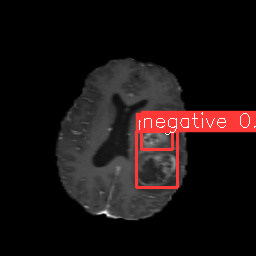

In [ ]:
from sahi.predict import get_prediction

result.export_visuals(export_dir="demo_data/")
from IPython.display import Image

Image("demo_data/prediction_visual.png")

In [ ]:
predictions_save_dir = './' + predictions[0].save_dir + '/labels'

TypeError: 'NoneType' object is not subscriptable

In [ ]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

In [ ]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('./axial_t1wce_2_class/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
text = """
path: ../axial_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [ ]:
metrics = trained_model.val(data="./test.yaml")

In [ ]:
test_save_dir = './' + str(metrics.save_dir)

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [ ]:
image_path = os.path.join(test_save_dir, 'val_batch0_pred.jpg')

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Read the image using OpenCV
img = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display

# Add a title to the plot (optional)
plt.title('Predicted Image')

# Show the plot
plt.axis('off')  # Hide axis ticks and labels
plt.show()

## [SAM(Segment Anything Model)](https://segment-anything.com/)

In [ ]:
real_path = os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg')

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = 0
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
model=YOLO('./runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]

In [ ]:
print(bbox)

In [ ]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()